In [1]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from brax import envs
from brax.io import mjcf
import jax
import flax.linen as nn
import jax.numpy as jnp
from wrappers import AutoResetWrapper

from custom_types import RNGKey, EnvState, Params
from typing import Any, Tuple, List
# from algorithms import QuaraticPPO, PPO
from mo_algorithms import MO_PPO
from buffer import PPOTransition
from networks import GCMLP, GC_PPO_Policy
from functools import partial
from utils import shuffle_transitions
from mo_utils import sample_task, mo_ppo_exploraive_rollout, calculate_td_lambda_returns, build_scoring_fn

/home_nfs/runjun/python_envs/qdax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
critic_hidden_layers: Tuple[int, ...] = (128, 128)
actor_hidden_layers: Tuple[int, ...] = (128, 128)

parallel_batch_size: int = 4096
discount: float = 0.99
td_lambda_discount: float = 0.95

# PPO configs
rollout_length = 128
action_noise_std: float = 0.1
fixed_std = True
include_last_action_in_obs=True

# actor_critic_iterations: int = 200 


# define learning rates
critic_learning_rate: float = 5e-4 # for critic training
policy_learning_rate: float = 5e-4 # Policy-Gradient step size


In [3]:
# set random seed
seed = 6666
loop_random_key = jax.random.PRNGKey(seed)
loop_random_key, subkey = jax.random.split(loop_random_key)
task_name = "ant"

# creat environment (Ant)
env = envs.create(env_name=task_name, episode_length=None, backend="mjx", auto_reset=False)
env = AutoResetWrapper(env) # custom auto reset


# preference_vector = jnp.array([2.0, 1.0, 1.0, 1.0])
# preference_vector = preference_vector / jnp.sqrt(jnp.sum(preference_vector**2))


# define networks
policy_network = GC_PPO_Policy(
    hidden_layer_sizes=actor_hidden_layers,
    action_dim=env.action_size,
    initial_std=action_noise_std * jnp.ones(env.action_size),
    kernel_init=jax.nn.initializers.orthogonal(jnp.sqrt(2)),
    kernel_init_final=jax.nn.initializers.orthogonal(0.01),
    # activation=nn.softplus,
    activation=nn.softplus,
    final_activation=jnp.tanh,
    # fixed_std=True,
    fixed_std=fixed_std,
)

critic_network = GCMLP(
    layer_sizes=critic_hidden_layers + (1,),
    kernel_init=jax.nn.initializers.orthogonal(jnp.sqrt(2)),
    activation=nn.softplus,
    final_activation=None,
)


ppo = MO_PPO(
    env, 
    policy_network, 
    critic_network, 
    policy_learning_rate, 
    critic_learning_rate, 
    fixed_std=fixed_std, 
    clip_ratio=0.2,
    entropy_gain=0.2,
    include_last_action_in_obs=include_last_action_in_obs,
    )

ppo_training_state = ppo.init(subkey)

explorative_rollout = mo_ppo_exploraive_rollout(
    policy_fn=policy_network.apply, 
    env_fn=env.step, 
    rollout_length=rollout_length, 
    )


In [4]:
loop_random_key, subkey = jax.random.split(loop_random_key)
subkeys = jax.random.split(subkey, num=parallel_batch_size)
states = jax.vmap(env.reset)(subkeys)
last_actions = jnp.zeros((parallel_batch_size, env.action_size))
step_count = jnp.zeros(parallel_batch_size)

In [5]:
scoring_fn = build_scoring_fn(env, policy_network.apply, jax.random.key(42), 1024)

In [30]:
num_iterations = 500

iteration_mean_returns = []
iteration_mean_rewards = []
iteration_mean_log_std = []
iteration_mean_gae = []

scores = []


for i in range(num_iterations):
    """
    1) sample preference vector

    2) pass this to the policy and rollout

    3) update policy and critic with ppo

    4) loop several iterations before testing
    """

    policy_params = ppo_training_state.policy_params
    critic_params = ppo_training_state.critic_params

    # sample task
    loop_random_key, subkey = jax.random.split(loop_random_key)
    subkeys = jax.random.split(subkey, num=parallel_batch_size)
    sampled_preferences = jax.vmap(sample_task)(subkeys)

    loop_random_key, subkey = jax.random.split(loop_random_key)
    subkeys = jax.random.split(subkey, num=parallel_batch_size)
    (
        states, last_actions, transitions
        ) = explorative_rollout(policy_params, states, last_actions, sampled_preferences, subkeys)


    iteration_mean_rewards.append(jnp.mean(jnp.mean(transitions.rewards, axis=-1)))
    iteration_mean_log_std.append(jnp.mean(transitions.action_log_std))

    
    last_obs = jnp.concatenate([states.obs, last_actions], axis=-1)
    v_values = ppo.calculate_v(critic_params, transitions.obs, sampled_preferences)


    final_v_value = critic_network.apply(critic_params, last_obs, sampled_preferences)
    td_lambda_returns, weights = calculate_td_lambda_returns(
        final_v_value,
        v_values, 
        transitions.rewards,
        jnp.clip(1 - transitions.truncations - transitions.dones, min=0.0),
        discount,
        td_lambda_discount,
        sampled_preferences,
        ) # rollout x parallelize


    # mean_change = jnp.average(td_lambda_returns - v_values, axis=0, weights=weights, keepdims=True) # 1 x parallelize
    # td_lambda_returns = td_lambda_returns + (1 - weights) * mean_change # corrected td_lambda_returns

    gaes = td_lambda_returns - v_values

    gae_mean = jnp.mean(gaes)
    gae_std = jnp.std(gaes)
    gaes = jnp.clip(gaes, gae_mean - 4 * gae_std, gae_mean + 4 * gae_std)
    
    gae_mean = jnp.mean(gaes)
    gae_std = jnp.std(gaes)
    gaes = jnp.clip(td_lambda_returns - v_values, gae_mean - 8 * gae_std, gae_mean + 8 * gae_std)


    iteration_mean_gae.append(gae_mean)
    if gae_mean < 0 :
        gaes = gaes - gae_mean


    transitions = transitions.replace(
        td_lambda_returns=td_lambda_returns,
        gaes=gaes,
        weights=weights,
        )
    
    loop_random_key, subkey = jax.random.split(loop_random_key)
    transitions = shuffle_transitions(subkey, transitions)
    
    transitions = jax.tree.map(
        lambda x: jnp.reshape(
            x,
            (
                -1,
                512,
                *x.shape[1:],
            ),
        ),
        transitions)

    ppo_training_state = ppo.train(ppo_training_state, transitions, critic_epoch=1, policy_epoch=1)

    iteration_mean_returns.append(jnp.mean(td_lambda_returns))

    if (i + 1) % 50 == 0:
        print("here", i + 1)
        fitness = scoring_fn(ppo_training_state.policy_params)
        scores.append(fitness)

    if (i + 1) % max([(num_iterations // 10), 1]) == 0:
        print(int((i + 1) / num_iterations * 100), "% complete")


here 50
10 % complete
here 100
20 % complete
here 150
30 % complete
here 200
40 % complete
here 250
50 % complete
here 300
60 % complete
here 350
70 % complete
here 400
80 % complete
here 450
90 % complete
here 500
100 % complete


In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

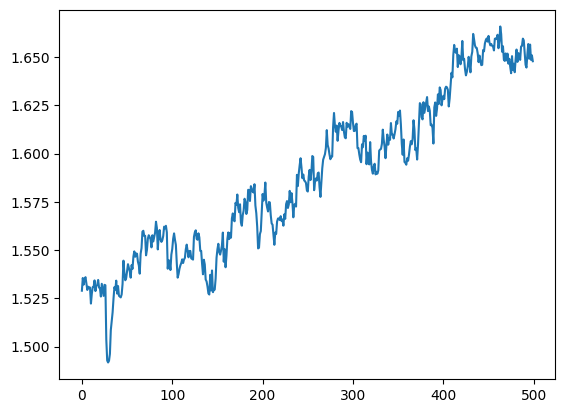

In [32]:
plt.plot(jnp.arange(num_iterations), iteration_mean_rewards)
# plt.plot(jnp.arange(num_iterations), iteration_mean_log_std)
plt.show()

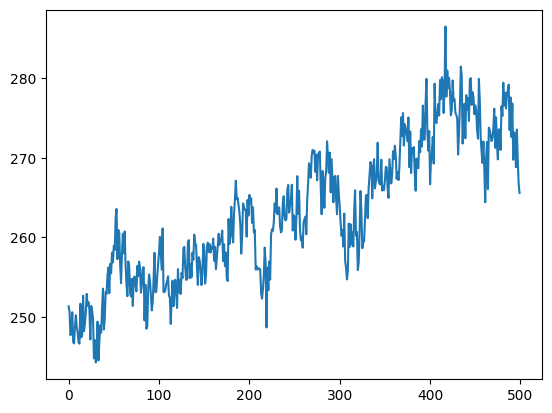

In [33]:
plt.plot(jnp.arange(num_iterations), iteration_mean_returns)
plt.show()

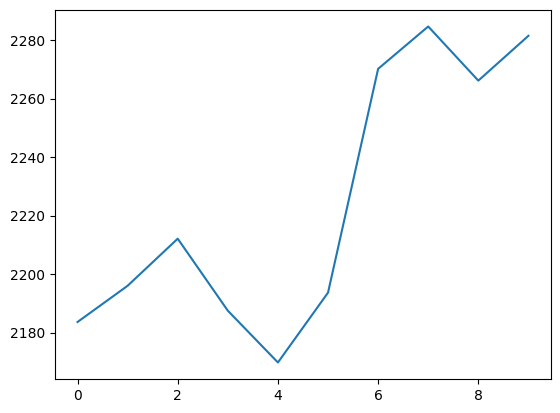

In [34]:
plt.plot(jnp.arange(len(scores)), scores)
plt.show()

In [35]:

jnp.mean(v_values)


Array(264.3515, dtype=float32)

In [36]:
print(
    jnp.mean(states.metrics["x_velocity"])
    )

print(
    jnp.mean(states.metrics["reward_ctrl"]) + 0.25
)
print(
    jnp.mean(states.metrics["x_velocity"] + states.metrics["reward_ctrl"] + 1)
    )
# iteration_mean_rewards[-1]

4.235628
-0.10716015
4.8784685


In [37]:
jnp.sum(gae_mean)

Array(2.0043967, dtype=float32)

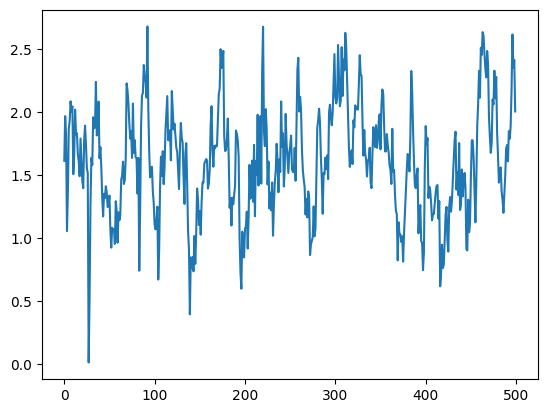

In [38]:
plt.plot(jnp.arange(num_iterations), iteration_mean_gae)
plt.show()

In [39]:
# jnp.sum(transitions.dones)

In [40]:
# plt.hist(jnp.reshape(gaes, -1), bins=20)
# plt.show()

In [41]:
mu_d = jnp.mean(jnp.exp(transitions.action_log_std), axis=-1, keepdims=True)